In [69]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

In [70]:
import salem

In [71]:
from glob import glob

In [72]:
import fiona

In [73]:
def convert_shape(country_name="New Caledonia"):
    with fiona.open('../shapefiles/shapes_{}_converted.shp'.format(country_name), 'w', 'ESRI Shapefile', sh_country.schema.copy(), crs = sh_country.crs) as output:
        for shape in sh_country:
            if shape['properties']['min_x'] < 0: 
                shape['properties']['min_x'] += 360 
            if shape['properties']['max_x'] < 0: 
                shape['properties']['max_x'] += 360
            if (len(shape['geometry']['coordinates']) == 1):
                coords = shape['geometry']['coordinates']
                coords_mod = coords.copy()
                for j in range(len(coords[0])): 
                    lon, lat = coords[0][j]
                    if lon < 0: 
                        lon += 360
                    coords_mod[0][j] = (lon, lat)
                shape['geometry']['coordinates'] = coords_mod  
            else: 
                for i in range(len(shape['geometry']['coordinates'])): 
                    coords = shape['geometry']['coordinates'][i]
                    coords_mod = coords.copy()
                    for j in range(len(coords[0])): 
                        lon, lat = coords[0][j]
                        if lon < 0: 
                            lon += 360
                        coords_mod[0][j] = (lon, lat)
                    shape['geometry']['coordinates'][i] = coords_mod  
            output.write(shape)

### past 4 months, 7 days chunks 

In [74]:
lfiles = glob('/Volumes/GDATA/data/CRW/BAA7dMAX/*.nc')

In [75]:
lfiles.sort()

In [76]:
lfiles = lfiles[-4:]

In [77]:
lfiles

['/Volumes/GDATA/data/CRW/BAA7dMAX/b5km_baa-max-7d_20171120.nc',
 '/Volumes/GDATA/data/CRW/BAA7dMAX/b5km_baa-max-7d_20171127.nc',
 '/Volumes/GDATA/data/CRW/BAA7dMAX/b5km_baa-max-7d_20171204.nc',
 '/Volumes/GDATA/data/CRW/BAA7dMAX/b5km_baa-max-7d_20171211.nc']

### reads in the BAA 7 days max

In [78]:
BAA = xr.open_mfdataset(lfiles)

In [79]:
BAA

<xarray.Dataset>
Dimensions:        (lat: 3600, lon: 7200, time: 4)
Coordinates:
  * lat            (lat) float32 89.975 89.925 89.875 89.825 89.775 89.725 ...
  * lon            (lon) float32 -179.975 -179.925 -179.875 -179.825 ...
  * time           (time) datetime64[ns] 2017-11-20T12:00:00 ...
Data variables:
    surface_flag   (time, lat, lon) int8 dask.array<shape=(4, 3600, 7200), chunksize=(1, 3600, 7200)>
    CRW_BAA_max7d  (time, lat, lon) float64 dask.array<shape=(4, 3600, 7200), chunksize=(1, 3600, 7200)>
    crs            (time) int16 -32767 -32767 -32767 -32767
Attributes:
    Conventions:                CF-1.6, ACDD-1.3, Unidata Observation Dataset...
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    title:                      NOAA Coral Reef Watch Daily Global 5-km Satel...
    summary:                    This is a product of NOAA Coral Reef Watch da...
    references:                 Liu, G, Heron SF, Eakin CM, Muller-Karger FE,...
    institution:    

### calculates the max over time

In [80]:
BAA = BAA.max('time')

In [81]:
BAA

<xarray.Dataset>
Dimensions:        (lat: 3600, lon: 7200)
Coordinates:
  * lat            (lat) float32 89.975 89.925 89.875 89.825 89.775 89.725 ...
  * lon            (lon) float32 -179.975 -179.925 -179.875 -179.825 ...
Data variables:
    surface_flag   (lat, lon) int8 dask.array<shape=(3600, 7200), chunksize=(3600, 7200)>
    CRW_BAA_max7d  (lat, lon) float64 dask.array<shape=(3600, 7200), chunksize=(3600, 7200)>
    crs            int16 -32767

### goes from 0 to 360 

In [82]:
BAA_rolled = BAA.assign_coords(lon=(BAA.lon % 360)).roll(lon=(BAA.dims['lon'] // 2))

/Users/nicolasf/anaconda/envs/IOOS/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:343: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


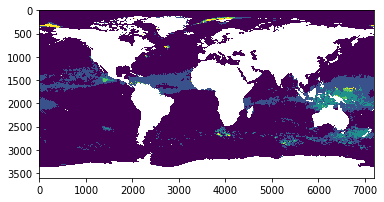

In [83]:
plt.imshow(BAA['CRW_BAA_max7d'].data)

/Users/nicolasf/anaconda/envs/IOOS/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:343: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


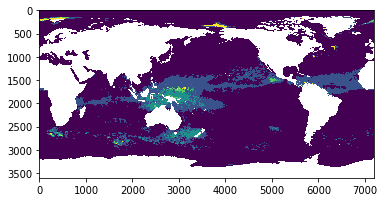

In [84]:
plt.imshow(BAA_rolled['CRW_BAA_max7d'].data)

In [85]:
BAA_rolled = BAA_rolled.sel(lon=slice(100, 300), lat=slice(50, -50))

/Users/nicolasf/anaconda/envs/IOOS/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:343: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


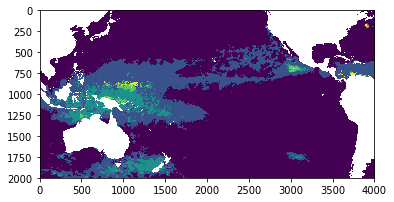

In [86]:
plt.imshow(BAA_rolled['CRW_BAA_max7d'].data)

In [87]:
BAA.close()

### loads in memory

In [88]:
BAA_rolled.load()

/Users/nicolasf/anaconda/envs/IOOS/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:343: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


<xarray.Dataset>
Dimensions:        (lat: 2000, lon: 4000)
Coordinates:
  * lat            (lat) float32 49.975 49.925 49.875 49.825 49.775 49.725 ...
  * lon            (lon) float32 100.025 100.075 100.125 100.175 100.225 ...
Data variables:
    surface_flag   (lat, lon) int8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    CRW_BAA_max7d  (lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    crs            int16 -32767

### reads in the masks

In [89]:
masks = xr.open_dataset('../data/reef_mask/compiled_5km_reef_mask_for_edit_20171113_buffer4pix.nc')

In [90]:
masks

<xarray.Dataset>
Dimensions:    (lat: 3600, lon: 7200)
Coordinates:
  * lon        (lon) float32 -179.975 -179.925 -179.875 -179.825 -179.775 ...
  * lat        (lat) float32 89.975 89.925 89.875 89.825 89.775 89.725 ...
Data variables:
    reef_mask  (lat, lon) uint8 ...
    land_mask  (lat, lon) uint8 ...

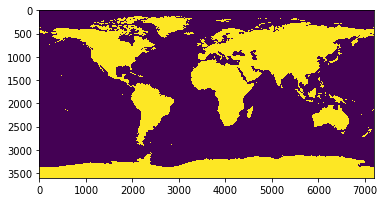

In [91]:
plt.imshow(masks['land_mask'].data)

In [92]:
masks_rolled = masks.assign_coords(lon=(masks.lon % 360)).roll(lon=(masks.dims['lon'] // 2))

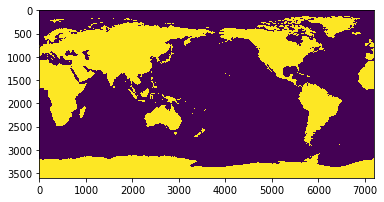

In [93]:
plt.imshow(masks_rolled['land_mask'].data)

In [94]:
land_mask = ~(masks_rolled['land_mask'].data.astype(np.bool))

In [95]:
land_mask = land_mask.astype(np.float32)

In [96]:
land_mask

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

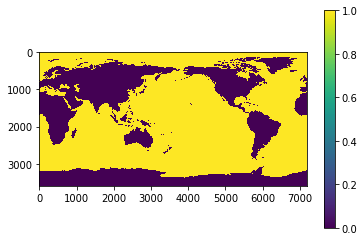

In [97]:
plt.imshow(land_mask); plt.colorbar()

In [98]:
masks_rolled['land_mask'] = (('lat','lon'), land_mask)

In [99]:
masks_rolled = masks_rolled.sel(lon=slice(100, 300), lat=slice(50, -50))

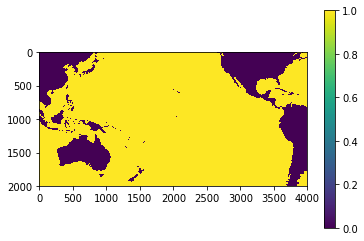

In [100]:
plt.imshow(masks_rolled['land_mask'].data); plt.colorbar()

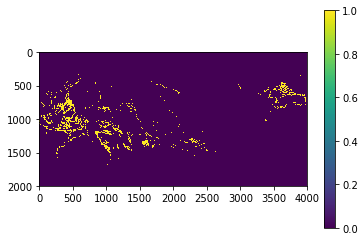

In [101]:
plt.imshow(masks_rolled['reef_mask'].data); plt.colorbar()

In [102]:
mask = masks_rolled['reef_mask'] * masks_rolled['land_mask']

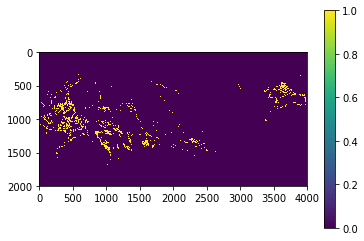

In [103]:
plt.imshow(mask); plt.colorbar()

In [104]:
mask_data = mask.data

In [105]:
mask_data[np.where(mask_data == 0)] = np.nan

In [106]:
d = {}
d['lat'] = (('lat'), mask.lat.data)
d['lon'] = (('lon'), mask.lon.data)
d['mask'] = (('lat','lon'), mask_data)

In [107]:
mask_dset = xr.Dataset(d)

In [108]:
mask_dset.to_netcdf('../data/combined_reef_mask.nc')

In [109]:
mask_data

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)

In [110]:
BAA_rolled['reef_mask'] = (('lat','lon'), mask_data)

In [111]:
if os.path.exists('../outputs/tmp.nc'):
    os.remove('../outputs/tmp.nc')

In [112]:
BAA_rolled.to_netcdf('../outputs/tmp.nc')

### reads the EEZ shapefile

In [113]:
shp_path = "/Users/nicolasf/drives/auck_projects/ICU14101/Working/ICU Water Watch/GIS map files"

In [114]:
shp = salem.read_shapefile(os.path.join(shp_path, "ALL_ICU_countries.shp"))

In [115]:
# shp.plot()

In [116]:
shp.head()

,ACP,COUNTRYNAM,COUNTRY_ID,FFA,FORUM,ICU,SOPAC,SPC,SPREP,Stress,TCSP,USP,area,geometry,min_x,max_x,min_y,max_y
0,0,New Caledonia,NC,0,0,2,0,0,0,-14,0,0,0.0,"POLYGON ((158.6108 -25.14667, 157.8011 -23.248...",156.255600,170.033300,-25.919891,-14.769438
1,0,Pitcairn Islands,PN,0,0,-3,0,0,0,0,0,0,0.0,"POLYGON ((-132.499382 -22.511733, -132.228513 ...",-133.405666,-121.133705,-28.385089,-20.530577
2,0,Papua New Guinea,PG,0,0,0,0,0,0,7,0,0,0.0,"POLYGON ((157.168058 -13.692712, 157.038334 -1...",139.200227,162.801941,-14.750038,2.591944
3,0,Solomon Islands,SB,0,0,-9,0,0,0,2,0,0,0.0,"POLYGON ((173.5906 -11.85417, 173.525754 -12.5...",154.585556,173.590600,-16.133050,-4.142221
4,0,Kiribati: Phoenix Islands,KI,0,0,-5,0,0,0,-1,0,0,0.0,"POLYGON ((-168.921636 -6.882211000000032, -170...",-177.883300,-167.366700,-7.785231,0.583333


In [117]:
def sanitize(x): 
    x = x.replace(" ","_")
    x = x.replace("/","")
    x = x.replace(":","")
    return x

In [118]:
shp.loc[:,'COUNTRYNAM']= shp.loc[:,'COUNTRYNAM'].apply(sanitize)

In [119]:
shp.head()

,ACP,COUNTRYNAM,COUNTRY_ID,FFA,FORUM,ICU,SOPAC,SPC,SPREP,Stress,TCSP,USP,area,geometry,min_x,max_x,min_y,max_y
0,0,New_Caledonia,NC,0,0,2,0,0,0,-14,0,0,0.0,"POLYGON ((158.6108 -25.14667, 157.8011 -23.248...",156.255600,170.033300,-25.919891,-14.769438
1,0,Pitcairn_Islands,PN,0,0,-3,0,0,0,0,0,0,0.0,"POLYGON ((-132.499382 -22.511733, -132.228513 ...",-133.405666,-121.133705,-28.385089,-20.530577
2,0,Papua_New_Guinea,PG,0,0,0,0,0,0,7,0,0,0.0,"POLYGON ((157.168058 -13.692712, 157.038334 -1...",139.200227,162.801941,-14.750038,2.591944
3,0,Solomon_Islands,SB,0,0,-9,0,0,0,2,0,0,0.0,"POLYGON ((173.5906 -11.85417, 173.525754 -12.5...",154.585556,173.590600,-16.133050,-4.142221
4,0,Kiribati_Phoenix_Islands,KI,0,0,-5,0,0,0,-1,0,0,0.0,"POLYGON ((-168.921636 -6.882211000000032, -170...",-177.883300,-167.366700,-7.785231,0.583333


In [120]:
dset_salem = salem.open_xr_dataset('../outputs/tmp.nc')

In [121]:
dset_salem

<xarray.Dataset>
Dimensions:        (lat: 2000, lon: 4000)
Coordinates:
  * lat            (lat) float32 49.975 49.925 49.875 49.825 49.775 49.725 ...
  * lon            (lon) float32 100.025 100.075 100.125 100.175 100.225 ...
Data variables:
    surface_flag   (lat, lon) int8 ...
    CRW_BAA_max7d  (lat, lon) float64 ...
    crs            int16 ...
    reef_mask      (lat, lon) float32 ...
Attributes:
    pyproj_srs:  +units=m +datum=WGS84 +proj=latlong 

In [122]:
shp.COUNTRYNAM.unique()

array(['New_Caledonia', 'Pitcairn_Islands', 'Papua_New_Guinea',
       'Solomon_Islands', 'Kiribati_Phoenix_Islands', 'Fiji', 'Tuvalu',
       'Northern_Cook_Islands', 'Kiribati_Line_Islands',
       'Federated_States_of_Micronesia', 'Samoa',
       'Kiribati_Gilbert_Islands', 'Wallis_&_Futuna', 'Tokelau',
       'Tuamotu__Gambier_Islands', 'Tonga', 'Niue',
       'Southern_Cook_Islands', 'Austral_Islands', 'Society_Islands',
       'Marquesas', 'Vanuatu_South', 'Vanuatu_North', 'Guam',
       'Northern_Marianas', 'Marshall_Islands', 'Nauru', 'Palau',
       'American_Samoa'], dtype=object)

In [124]:
for country_name in shp.COUNTRYNAM.unique(): 
    sh_country = shp.query("COUNTRYNAM == '{}'".format(country_name))
    sh_country.to_file('../shapefiles/shapes_{}'.format(country_name))
    sh_country = fiona.open('../shapefiles/shapes_{}'.format(country_name))
    convert_shape(country_name)
    sh_country = salem.read_shapefile('../shapefiles/shapes_{}_converted.shp'.format(country_name))
    ds_subset = dset_salem.salem.subset(shape=sh_country, margin=2)
    ds_subset_roi = ds_subset.salem.roi(shape=sh_country)
    masked_roi = ds_subset_roi['CRW_BAA_max7d'] * ds_subset_roi['reef_mask']
    masked_roi = masked_roi.stack(z=('lat','lon'))
    df = masked_roi.to_dataframe(name='masked_roi')
    df_na = df.dropna()
    summary  = df_na.describe(percentiles=[0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9])
    summary = summary.T
    counts = pd.value_counts(df_na.iloc[:,0])
    counts = counts.reindex(range(5))
    counts = counts.replace(np.nan, 0)
    counts = counts.to_frame().T
    summary = pd.concat([summary, counts], axis=1)
    summary.index.name = "country"
    summary.index = [country_name]
    summary.to_csv('../outputs/{}_summary.csv'.format(country_name))

In [125]:
!ls ../outputs/

American_Samoa_summary.csv
Austral_Islands_summary.csv
BAA
BAA_4weeks_max_summary.csv
CSFV2_outlook_monthly_90th_per_summary_table_from_20171210.csv
CSFV2_outlook_summary_table_from_20171210.csv
CSFV2_outlook_weekly_90th_per_summary_table_from_20171210.csv
Federated_States_of_Micronesia_summary.csv
Fiji_summary.csv
Guam_summary.csv
Kiribati_Gilbert_Islands_summary.csv
Kiribati_Line_Islands_summary.csv
Kiribati_Phoenix_Islands_summary.csv
Marquesas_summary.csv
Marshall_Islands_summary.csv
Nauru_summary.csv
New_Caledonia_summary.csv
Niue_summary.csv
Northern_Cook_Islands_summary.csv
Northern_Marianas_summary.csv
Palau_summary.csv
Papua_New_Guinea_summary.csv
Pitcairn_Islands_summary.csv
Samoa_summary.csv
Society_Islands_summary.csv
Solomon_Islands_summary.csv
Southern_Cook_Islands_summary.csv
Tokelau_summary.csv
Tonga_summary.csv
Tuamotu__Gambier_Islands_summary.csv
Tuvalu_summary.csv
Vanuatu_North_summary.csv
Vanuatu_South_summary.csv

tmp.nc


In [128]:
lfiles = glob("../outputs/*_summary.csv")

In [129]:
len(lfiles)

29

In [130]:
data = pd.read_csv(lfiles[0], index_col=0)

In [131]:
data

,count,mean,std,min,10%,25%,50%,60%,70%,80%,90%,max,0,1,2,3,4
New_Caledonia,4647.0,0.06671,0.249545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4337.0,310.0,0.0,0.0,0.0


In [132]:
dl = [] 
for f in lfiles: 
    d = pd.read_csv(f, index_col=0)
    dl.append(d)

In [133]:
dlf = pd.concat(dl, axis=0)

In [134]:
dlf

,count,mean,std,min,10%,25%,50%,60%,70%,80%,90%,max,0,1,2,3,4
New_Caledonia,4647.0,0.066710,0.249545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4337.0,310.0,0.0,0.0,0.0
Tonga,1616.0,0.344059,0.475208,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1060.0,556.0,0.0,0.0,0.0
Kiribati_Phoenix_Islands,612.0,0.032680,0.177942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,592.0,20.0,0.0,0.0,0.0
Tuvalu,1339.0,1.050784,0.219639,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,1271.0,68.0,0.0,0.0
Tokelau,236.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,236.0,0.0,0.0,0.0
Society_Islands,1337.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1337.0,0.0,0.0,0.0,0.0
Austral_Islands,560.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,560.0,0.0,0.0,0.0,0.0
Federated_States_of_Micronesia,5229.0,1.424555,0.920468,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,0.0,4248.0,79.0,565.0,337.0
Solomon_Islands,6016.0,1.413231,0.492455,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,0.0,3530.0,2486.0,0.0,0.0
Pitcairn_Islands,242.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,242.0,0.0,0.0,0.0,0.0


In [135]:
dlf.to_csv('../outputs/BAA_4weeks_max_summary.csv')

In [136]:
dlf.sort_values("90%", ascending=False)

,count,mean,std,min,10%,25%,50%,60%,70%,80%,90%,max,0,1,2,3,4
Papua_New_Guinea,12824.0,1.821351,0.617893,0.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,180.0,3258.0,8059.0,1327.0,0.0
Federated_States_of_Micronesia,5229.0,1.424555,0.920468,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,0.0,4248.0,79.0,565.0,337.0
Solomon_Islands,6016.0,1.413231,0.492455,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,0.0,3530.0,2486.0,0.0,0.0
Palau,803.0,1.288917,0.453542,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,571.0,232.0,0.0,0.0
Vanuatu_North,1750.0,0.644000,0.478952,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,623.0,1127.0,0.0,0.0,0.0
Tonga,1616.0,0.344059,0.475208,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1060.0,556.0,0.0,0.0,0.0
Northern_Cook_Islands,476.0,0.506303,0.500486,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,235.0,241.0,0.0,0.0,0.0
Fiji,5578.0,0.607386,0.620633,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2599.0,2570.0,409.0,0.0,0.0
Kiribati_Line_Islands,726.0,0.179063,0.383670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,596.0,130.0,0.0,0.0,0.0
Samoa,395.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,395.0,0.0,0.0,0.0


In [137]:
!open ../outputs/BAA_4weeks_max_summary.csv